# preparations

## loading necessary libraries

In [94]:
%pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## noise model based on IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [95]:
# error probabilities
p_meas = 0.39/100
p_reset = 0.39/100
p_gate1 = 0.06/100
p_gate2 = 0.6/100

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

## miscellaneous

In [97]:
#graph plotter
def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([j, i])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

# 
def Chebyshev(x: float, L:  float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

def grover_parameter_finder(P: float, Lambda: float, N: int):
    step = 1 / (1 << N)
    L_bound = 1
    p = 0
    while p < P:
        delta = step
        l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while l > L_bound:
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while delta < 1 and p < P:
            p = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)
            if p < P:
                delta += step
                l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        if delta == 1:
            L_bound += 1
            p = 0

    return delta, l, p

## circuits

### Quantum Fourier Transform

In [33]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)

        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    return QC.to_gate()

### cost/energy oracle:**bold text** $U_C | x \rangle | y \rangle = | x \rangle | y - C (x) \rangle$

In [34]:
def EnergyOracle(QuadraticForm: list[list[int]], digits: int):

    QRegX = QuantumRegister(len(QuadraticForm))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QFT = QuantumFourierTransform(digits)
    QC.append(QFT, QRegY)
    
    # Phasers
    for i, v in enumerate(QuadraticForm):
        theta = - np.pi * v[i]
        # QRegY is reversed below to save on swaps in QFT
        for q in reversed(QRegY):
            QC.cp(theta, QRegX[i], q)
            theta /= 2

        for j, w in enumerate(QuadraticForm[i][i + 1:]):
            if w != 0:
                theta = - 2 * np.pi * w
                # QRegY is reversed below to save on swaps in QFT
                for q in reversed(QRegY):
                    QC.mcp(theta, [QRegX[i], QRegX[i + 1 + j]], q)
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

### Grover Fixed Point Search for graph cuts

In [35]:
def GroverForMaxCut(QuadraticForm: list[list[int]], digits: int, y: int, delta: float, Lambda: float, noise: bool):

    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    gamma = np.sqrt(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2))
    angles = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / (2 * l + 1)))) for j in range(1, l + 1)]

    # one quantum register for each vertex
    QRegX = QuantumRegister(len(QuadraticForm), "x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    for q in QRegX:
        QC.initialize([1, 0], q)

    for i, q in enumerate(QRegY):
        # y - 1 is used so that states with f(x) >= y are flagged
        bit = ((y-1)>>(digits-i-1))&1
        QC.initialize([1 - bit, bit], q)

    QC.h(QRegX)
    
    CostGate = EnergyOracle(QuadraticForm, digits)
    CostGate.label = "Cost Gate"
    CostGateInverse = CostGate.inverse()
    CostGateInverse.label = "Cost Gate Inverse"

    for _, (alpha, beta) in enumerate(zip(angles, reversed(angles))):

        # S_t (beta)
        QC.append(CostGate, QRegX[:] + QRegY[:])
        QC.p(beta, QRegY[0])
        QC.append(CostGateInverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    QC.save_statevector()

    # simulation; need to add density matrix at some point
    simulator = AerSimulator(method="statevector", noise_model=fake_aria) if noise else AerSimulator(method="statevector")
    #results = execute(QC, simulator).result()
    psi = Statevector(execute(QC, simulator).result().get_statevector()).probabilities(np.arange(len(QRegX)))

    return psi

# parameters & testing:

y	Lambda	MaxCut	digits	delta	l	prob
7	0.3	9	4	0.31	1	90.0%



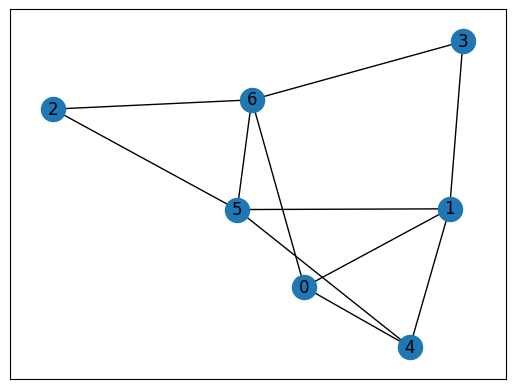

In [49]:
# graph size
NumberOfVerticies = 7 # must be <= 18 to fit in Aria
edge_probability = 0.5

# Grover target probability
P_L = 0.9


# random, connected graph
disconnected = True
while disconnected:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.rand() < edge_probability:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])
    disconnected = (NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1)

NumberOfEdges = np.trace(GraphLaplacian) >> 1

# Erdos-Edwards bound for connected graphs
y = int(np.ceil((2 * NumberOfEdges + NumberOfVerticies - 1) / 4))

digits = 1 + int(np.ceil(np.log2(max(y, NumberOfEdges + 1 - y)))) if NumberOfVerticies > 2 else 2

maxdeg = [0, 0]
for i in range(NumberOfVerticies):
    if GraphLaplacian[i][i] > maxdeg[1]:
        maxdeg = [i, GraphLaplacian[i][i]]

if maxdeg[0] + 1 != NumberOfVerticies:
    GraphLaplacian[[maxdeg[0], -1], :] = GraphLaplacian[[-1, maxdeg[0]], :]
    GraphLaplacian[:, [maxdeg[0], -1]] = GraphLaplacian[:, [-1, maxdeg[0]]]

createGraph(GraphLaplacian)

QuadraticForm = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1),np.arange(NumberOfVerticies - 1))]

MaxCut, R = y, 0
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies - 1)])
    cut = np.matmul(conf, np.matmul(QuadraticForm, np.transpose(conf)))
    if cut > MaxCut:
        MaxCut = cut
    if cut >= y:
        R += 1

Lambda = R * pow(2, 1 - NumberOfVerticies)
delta, l, prob = grover_parameter_finder(P_L, Lambda, 12)
print(f"y\tLambda\tMaxCut\tdigits\tdelta\tl\tprob\n{y}\t{round(Lambda, 2)}\t{MaxCut}\t{digits}\t{round(delta, 2)}\t{l}\t{round(prob, 2) * 100}%\n")

### simulation:

In [52]:
noise = True
#noise = False

start_time = time.time()
print(f"\ncomputation with Grover Fixed Point Search...\n")
psi = GroverForMaxCut(QuadraticForm, digits, y, delta, Lambda, noise)
end_time = time.time()
print(f"done in {round(end_time - start_time, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 31.05 seconds



In [91]:
s = "simulation with noise\n" if noise else "simulation without noise\n"

s += f"\nthe graph:\n----------\nMaxCut\t\t\t= {MaxCut}\nErdos-Edwards bound\t= {y}\n\n"

#for row in GraphLaplacian:
#    s += f"{row.view()}\n"

l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1

s += f"Grover parameters:\n------------------\nLambda\t= {round(Lambda, 3)}\ndelta\t= {round(delta, 2)}\nl\t= {l}\n\n"

s += f"results with Grover:\n--------------------\n\n"

M = 0
cov = 0
success = 0
distribution = {}
for i in range(MaxCut + 1):
    distribution[i] = 0
#postfix = ""
for i, p in enumerate(psi):
    conf = [(i >> j)&1 for j in range(len(QuadraticForm))]
    cut = np.matmul(conf, np.matmul(QuadraticForm, np.transpose(conf)))
    distribution[cut] += p
    M += p * cut
    cov += p * cut * cut
    if cut >= y:
        #postfix += f"P({conf}) = {round(p, 3)}\t!!!\n"
        success += p
    #else:
        #postfix += f"P({conf}) = {round(p, 3)}\t:(\n"
    
s += f"expectation\t= {round(M, 3)}\nvariance\t= {round(np.sqrt(cov - M*M), 3)}\n\n"
s += f"success probability = {round(success * 100, 2)}% (theoretical value = {round(prob, 2) * 100}%)"
#s += "\n\n" + postfix
#s += f"\n\n||state|| ~ {round(np.sqrt(np.sum(psi)), 5)}"

print(s)

plt.bar(distribution.keys(), distribution.values(), width=0.5, color="midnightblue", tick_label=[i for i in range(MaxCut + 1)])
plt.show()

simulation with noise

the graph:
----------
MaxCut			= 9
Erdos-Edwards bound	= 7

Grover parameters:
------------------
Lambda	= 0.297
delta	= 0.31
l	= 1

results with Grover:
--------------------

expectation	= 5.638
variance	= 1.631

success probability = 34.05% (theoretical value = 90.0%)
